In [1]:
import sys
import os
from pathlib import Path
import itk
import matplotlib.pyplot as plt

# Pre-load ITKMontage components
itk.auto_progress(1)
itk.TileConfiguration.GetTypes()
itk.auto_progress(0)

Loading ITKPyBase... Loading ITKPyBase... Loading ITKCommon... Loading ITKCommon... Loading ITKStatistics... Loading ITKStatistics... Loading ITKImageFilterBase... Loading ITKImageFilterBase... Loading ITKTransform... Loading ITKTransform... Loading ITKImageFrequency... Loading ITKImageFrequency... Loading ITKIOImageBase... Loading ITKIOBMP... Loading ITKIOBMP... Loading ITKIOBioRad... Loading ITKIOBioRad... Loading ITKIOBruker... Loading ITKIOBruker... Loading ITKIOGDCM... Loading ITKIOGDCM... Loading ITKIOIPL... Loading ITKIOIPL... Loading ITKIOGE... Loading ITKIOGE... Loading ITKIOGIPL... Loading ITKIOGIPL... Loading ITKIOHDF5... Loading ITKIOHDF5... Loading ITKIOJPEG... Loading ITKIOJPEG... Loading ITKIOJPEG2000... Loading ITKIOJPEG2000... Loading ITKIOTIFF... Loading ITKIOTIFF... Loading ITKIOLSM... Loading ITKIOLSM... Loading ITKIOMINC... Loading ITKIOMINC... Loading ITKIOMRC... Loading ITKIOMRC... Loading ITKIOMeta... Loading ITKIOMeta... Loading ITKIONIFTI... Loading ITKIONIFTI

<itkTemplate itk::TileConfiguration>
Options:
  [2,]
  [3,]
  [4,]


Loading Montage... 

In [2]:
input_folder = Path("sample")
output_folder = Path("Output")
output_file = Path("OutputMontage.mhd")

if not output_file.is_absolute():
    output_file = (output_folder / output_file).resolve()

os.makedirs(output_folder, exist_ok=True)

In [3]:
tile_path = "sample\TileConfiguration.txt"
dimension = 2
stage_tiles = itk.TileConfiguration[dimension]()
stage_tiles.Parse(str(tile_path))

In [4]:
# Load tiles

color_images = []  # for mosaic creation
grayscale_images = []  # for registration
for t in range(stage_tiles.LinearSize()):
    origin = stage_tiles.GetTile(t).GetPosition()
    filename = str(input_folder / stage_tiles.GetTile(t).GetFileName())
    image = itk.imread(filename)
    spacing = image.GetSpacing()

    # tile configurations are in pixel (index) coordinates
    # so we convert them into physical ones
    for d in range(dimension):
        origin[d] *= spacing[d]

    image.SetOrigin(origin)
    color_images.append(image)

    image = itk.imread(filename, itk.F)  # read as grayscale
    image.SetOrigin(origin)
    grayscale_images.append(image)

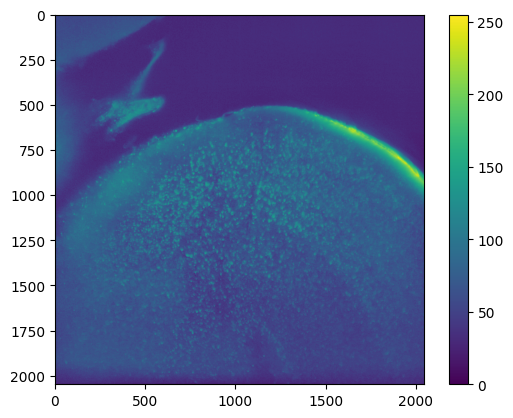

In [5]:
%matplotlib inline

# View one tile
TILE_INDEX = 10
plt.imshow(color_images[TILE_INDEX])
plt.colorbar()
plt.show()

In [6]:
# only float is wrapped as coordinate representation type in TileMontage
montage = itk.TileMontage[type(grayscale_images[0]), itk.F].New()
montage.SetMontageSize(stage_tiles.GetAxisSizes())
for t in range(stage_tiles.LinearSize()):
    montage.SetInputTile(t, grayscale_images[t])

print("Computing tile registration transforms")
montage.Update()

Computing tile registration transforms


In [7]:
print("Writing tile transforms")
actual_tiles = stage_tiles  # we will update it later
for t in range(stage_tiles.LinearSize()):
    index = stage_tiles.LinearIndexToNDIndex(t)
    regTr = montage.GetOutputTransform(index)
    tile = stage_tiles.GetTile(t)
    itk.transformwrite([regTr], str(output_folder / (tile.GetFileName() + ".tfm")))

    # calculate updated positions - transform physical into index shift
    pos = tile.GetPosition()
    for d in range(dimension):
        pos[d] -= regTr.GetOffset()[d] / spacing[d]
    tile.SetPosition(pos)
    actual_tiles.SetTile(t, tile)
actual_tiles.Write(str(output_folder / "TileConfiguration.registered.txt"))

Writing tile transforms


In [12]:
print("Producing the mosaic")
resampleF = itk.TileMergeImageFilter[type(color_images[0]), itk.D].New() #  line creating the problem
resampleF.SetMontageSize(stage_tiles.GetAxisSizes())
for t in range(stage_tiles.LinearSize()):
    resampleF.SetInputTile(t, color_images[t])
    index = stage_tiles.LinearIndexToNDIndex(t)
    resampleF.SetTileTransform(index, montage.GetOutputTransform(index))
resampleF.Update()
itk.imwrite(resampleF.GetOutput(), str(output_file))
print("Resampling complete")

Producing the mosaic
Resampling complete


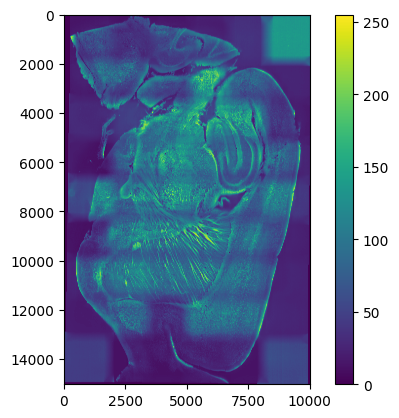

In [13]:
plt.imshow(resampleF.GetOutput())
plt.colorbar()
plt.show()

In [14]:
itk.imwrite(resampleF.GetOutput(), "resampled_image.tif")

In [ ]:
# debug cell
itk.TileMergeImageFilter.GetTypes()

<itkTemplate itk::TileMergeImageFilter>
Options:
  [<class 'itk.itkImagePython.itkImageD2'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageD3'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageD4'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageF2'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageF3'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageF4'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageSS2'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageSS3'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageSS4'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageUC2'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageUC3'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageUC4'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageUS2'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageUS3'>, <itkCType double>]
  [<class 'itk.itkImagePython.itkImageUS4'>, <itkCType double

In [ ]:
for image in color_images:
    print(type(image))


<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkImagePython.itkImageUC2'>
<class 'itk.itkI

In [ ]:
for image in color_images:
    pixel_type = itk.template(image)[1][0]
    print("Pixel Type:", pixel_type)

Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
Pixel Type: <itkCType unsigned char>
P